# Train and run wflow_sbm surrogate model

The surrogate emulates Actual Evapotranspiration and Volumetric Water Content (top 10 cm) produced from Wflow_sbm over the Alpine region at 1 km spatial resolution and daily time steps. 

The repository offers a very small dataset in the demodata folder. Uncomment the jupyter notebook cell "DEMO" and comment the cell "ALPS" in order to train the model.

The figures at the end of the notebook show the surrogate outputs on the Alps, however the training data are not yet available to reproduce the results.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path

import dask

from hython.preprocess import apply_normalization
from hython.sampler import RegularIntervalSampler, DataLoaderSpatialSampler
from hython.utils import missing_location_idx, reconstruct_from_missing, load, store_as_zarr, read_from_zarr
from hython.models.lstm import CustomLSTM

# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler
from hython.utils import predict, prepare_for_plotting
from hython.viz import map_bias, map_pbias, map_pearson, map_at_timesteps, ts_compare, plot_sampler


/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Settings

In [4]:
wflow_model =  "alps1km_eobs"

surrogate_experiment_name = "s0001"

dynamic_names = ["precip", "pet", "temp"] #  WFLOW forcings, input features of the surrogate
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] # WFLOW static parameters, input features of the surrogate
target_names = [ "vwc","actevap" ] # WFLOW outputs, targets of the surrogate

train_start = "2016-01-01"
train_end = "2018-12-31"

test_start = "2019-01-01"
test_end = "2020-12-31"

train_range = slice(train_start,train_end)
test_range = slice(test_start, test_end)

# trained was done with spatial sampling

spatial_sampling = True


# for plotting the metrics

remove_lakes =True


# paths

wd = Path("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training")

input_dir_path = Path('/mnt/CEPH_PROJECTS/InterTwin/Wflow/models') / wflow_model

# path to directory to save model weights after training
dp_surrogate_model = Path("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_model")

surrogate_data = wd / f"{wflow_model}.zarr"

surrogate_model = dp_surrogate_model / f"{wflow_model}_{surrogate_experiment_name}.pt"

In [9]:
targets = xr.open_dataset(input_dir_path / "run_default" / "output.nc", chunks= {"time":200}).sel(layer=1).isel(lat=slice(None, None, -1))

In [10]:
Xd = read_from_zarr(url=surrogate_data , group="xd", multi_index="gridcell").sel(time = train_range).xd
Xs = read_from_zarr(url=surrogate_data , group="xs", multi_index="gridcell").xs
Y = read_from_zarr(url=surrogate_data , group="y", multi_index="gridcell").sel(time = train_range).y

In [11]:
Xd_test = read_from_zarr(url=surrogate_data, group="xd", multi_index="gridcell").sel(time = test_range).xd
Y_test = read_from_zarr(url=surrogate_data, group="y", multi_index="gridcell").sel(time = test_range).y

In [15]:
mask_missing = read_from_zarr(url=surrogate_data, group="mask" ).mask
mask_lake = read_from_zarr(url=surrogate_data, group="mask_lake" ).mask_lake

In [16]:
wflow_lakes = Xs.sel(feat="wflow_lakeareas").unstack()
wflow_dem = Xs.sel(feat="wflow_dem").unstack()
wflow_landuse = Xs.sel(feat="wflow_landuse").unstack()

In [17]:
# train 
Xd = Xd.sel(feat=dynamic_names)
Xs = Xs.sel(feat=static_names)
Y = Y.sel(feat=target_names)

# test 
Y_test = Y_test.sel(feat=target_names)
Xd_test = Xd_test.sel(feat=dynamic_names)

# Model hyper parameters

In [18]:
spatial_batch_size = 256
temporal_sampling_size = 150 
seq_length = 360 # days

hidden_size = 24

model_params={
    "input_size": len(dynamic_names), 
    "hidden_size": hidden_size, 
    "output_size": len(target_names),
    "number_static_predictors": len(static_names), 

}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
# Define the spatial samplers for both training and validation sets. Remeber the subsets should not overlap, so choose different origins.
if spatial_sampling:
    intervals = (10, 10) # every n km
    train_origin = (0, 0)
    val_origin = (5, 5)
    
    spatial_train_sampler = RegularIntervalSampler(intervals = intervals, origin = train_origin)
    spatial_val_sampler = RegularIntervalSampler(intervals = intervals, origin = val_origin) 

    # Apply the samplers: return the cell indices that can be used later in training and validation to sample the whole spatial domain.
    data2d  = wflow_dem.values
    
    sampler_train_meta = spatial_train_sampler.sampling_idx(data2d, missing_mask)
    sampler_val_meta = spatial_val_sampler.sampling_idx(data2d, missing_mask)

    # some useful metadata
    print(sampler_train_meta)

    # check location of training and validation sets
    #_ = plot_sampler(wflow_dem, sampler_train_meta, sampler_val_meta, figsize= (8, 8 ), markersize = 3)
else:
    idx = missing_location_idx(Xs)

    Xd_nomissing = Xd[~idx]
    Xs_nomissing = Xs[~idx]
    Y_nomissing = Y[~idx]

SamplerResult(
 - id_grid_2d: (689, 1177) 
 - idx_sampled_1d: (8142,) 
 - idx_sampled_1d_nomissing: (8072,)) 
 - idx_missing_1d: (7105,) 
 - sampled_grid_dims: (69, 118) 
 - xr_coords: None


In [22]:
# Normalizing
if spatial_sampling:

    # statistics from training
    _, d_m, d_std = apply_normalization(Xd[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
    _, s_m, s_std = apply_normalization(Xs[sampler_train_meta.idx_sampled_1d_nomissing], type = "space", how ='standard')
    _, y_m, y_std = apply_normalization(Y[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')

    # use statistics from training to normalize test set
    Xs = apply_normalization(Xs, type="space", how="standard",  m1 = s_m, m2 = s_std).compute()
    Xd_test = apply_normalization(Xd_test, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute()
    Y_test = apply_normalization(Y_test, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute()
else:
    _, d_m, d_std = apply_normalization(Xd_nomissing, type = "spacetime", how ='standard')
    _, s_m, s_std = apply_normalization(Xs_nomissing, type = "space", how ='standard')
    _, y_m, y_std = apply_normalization(Y_nomissing, type = "spacetime", how ='standard')

    Xd_nomissing = apply_normalization(Xd_nomissing, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute()
    Xs_nomissing = apply_normalization(Xs_nomissing, type="space", how="standard",  m1 = s_m, m2 = s_std).compute()
    Y_nomissing = apply_normalization(Y_nomissing, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute()

    Xd_test = apply_normalization(Xd_test, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute()
    Xs_test = apply_normalization(Xs_test, type="space", how="standard",  m1 = s_m, m2 = s_std).compute()
    Y_test = apply_normalization(Y_test, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute()

In [ ]:
d_m = d_m.compute()
d_std = d_std.compute()
s_m = s_m.compute()
s_std = s_std.compute()
y_m = y_m.compute()
Y_std = y_std.compute()

In [23]:
Xd_test = Xd_test.values
Y_test = Y_test.values
Xs = Xs.values

# Initialize Model

In [26]:
model = CustomLSTM(model_params)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=9, out_features=24, bias=True)
  (lstm): LSTM(24, 24, batch_first=True)
  (fc1): Linear(in_features=24, out_features=2, bias=True)
)

In [27]:
model.load_state_dict(torch.load(surrogate_model))

<All keys matched successfully>

In [28]:
def compute_kge(y_target,y_pred):
    observed = y_target
    simulated = y_pred

    if np.any(np.isnan(observed)) or np.any(np.isnan(simulated)):
        
        return np.array([np.nan,np.nan,np.nan, np.nan])

    r = np.corrcoef(observed, simulated)[1, 0]
    alpha = np.std(simulated, ddof=1) /np.std(observed, ddof=1)
    beta = np.mean(simulated) / np.mean(observed)
    kge = 1 - np.sqrt(np.power(r-1, 2) + np.power(alpha-1, 2) + np.power(beta-1, 2))
    return np.array([kge, r, alpha, beta ])



# Inference 

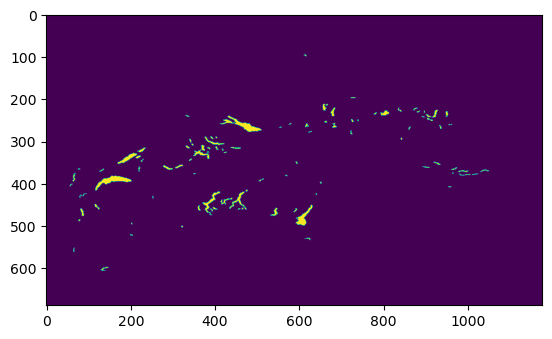

In [57]:
if remove_lakes:
    mask_lakes = (wflow_lakes[::-1].values > 0).astype(np.bool_)
plt.imshow(mask_lakes)

In [30]:
# predict over the whole spatial domain using the model trained over the subsample
yhat = predict(Xd_test, Xs, model, spatial_batch_size, device=device)
yhat.shape

(810953, 731, 2)

In [31]:
lat, lon, time = len(wflow_dem.lat),len(wflow_dem.lon), Xd_test.shape[1]
lat*lon ,time

(810953, 731)

In [32]:
# to original scale
yhat = (yhat*y_std) + y_m

## Volumetric Water Content (SM)

In [59]:
# reshape data for plotting
y_target, y_pred = prepare_for_plotting(y_target=Y_test[:,:,[0]], y_pred = yhat[:,:,[0]], shape = (lat, lon, time), coords = targets.sel(time=test_range).coords)
y_target.shape

(689, 1177, 731)

In [60]:
# to original scale
y_target = (y_target*y_std[0]) + y_m[0]

In [61]:
y_target = y_target.chunk({"lat":20, "lon":20, "time":-1})
y_pred = y_pred.chunk({"lat":20, "lon":20, "time":-1})

In [63]:
if remove_lakes:
    y_target = y_target.where(~mask_lakes[...,None])
    y_pred = y_pred.where(~mask_lakes[...,None])

In [37]:
cmap = plt.colormaps['Blues']
cmap.set_bad("lightgrey")

In [50]:
kge = xr.apply_ufunc(compute_kge, y_pred, y_target, 
                     input_core_dims=[["time"],["time"]] , 
                     output_core_dims= [["kge"]], 
                     output_dtypes=[float],
                     vectorize=True,
                     dask="parallelized",
                     dask_gufunc_kwargs = {"output_sizes":{"kge":4}}
                    )
kge  = kge.compute()
kge = kge.assign_coords({"kge":["kge","r", "alpha", "beta"]})

<xarray.DataArray (lat: 689, lon: 1177, kge: 4)>
dask.array<transpose, shape=(689, 1177, 4), dtype=float64, chunksize=(20, 20, 4), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 5.079 5.088 5.098 5.107 ... 15.83 15.84 15.85 15.86
  * lat      (lat) float64 50.03 50.02 50.01 50.0 ... 43.75 43.74 43.73 43.72
    layer    float64 1.0
Dimensions without coordinates: kge

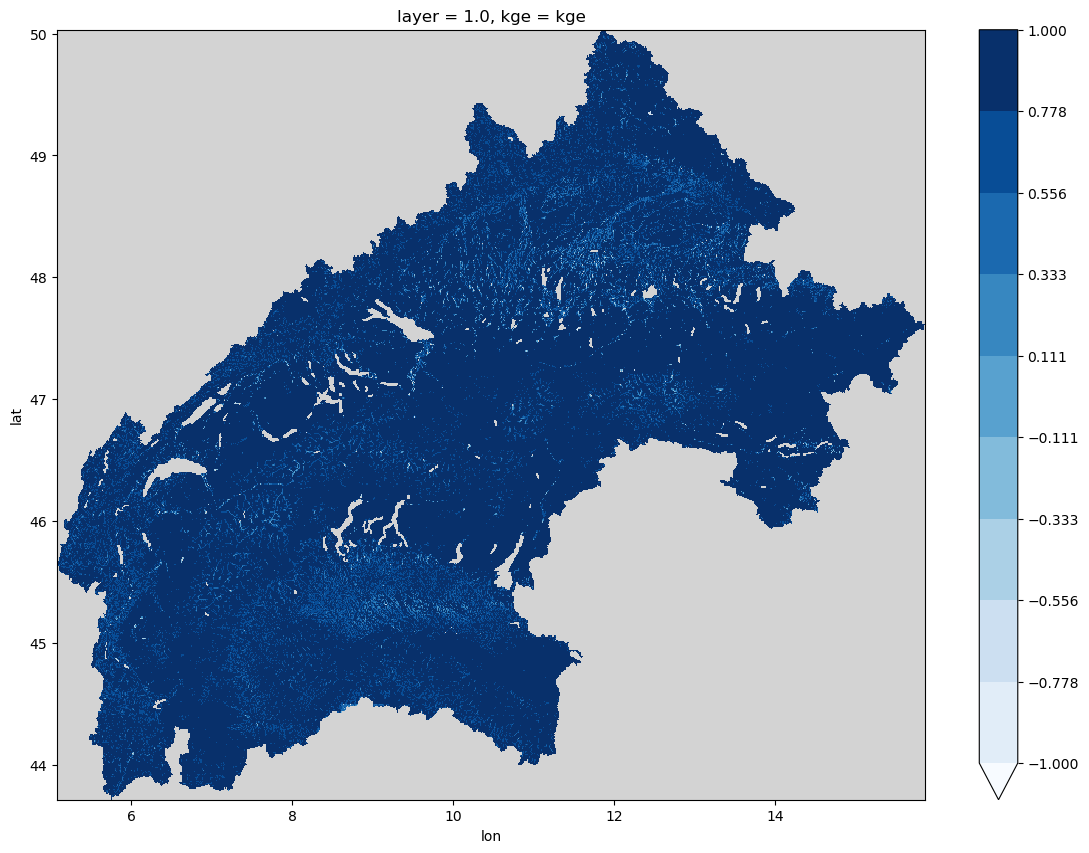

In [59]:
kge[...,0].plot(cmap=cmap,figsize=(14,10), levels=10, vmax=1)

In [ ]:
plt.figure(figsize=(20,5))
plt.scatter(wflow_dem.values.flatten(), kge[...,0].values.flatten(), s=1, alpha=0.3)
#plt.hexbin(wflow_dem.values.flatten(), kge[...,0].values.flatten(), bins=1000,gridsize=1000)

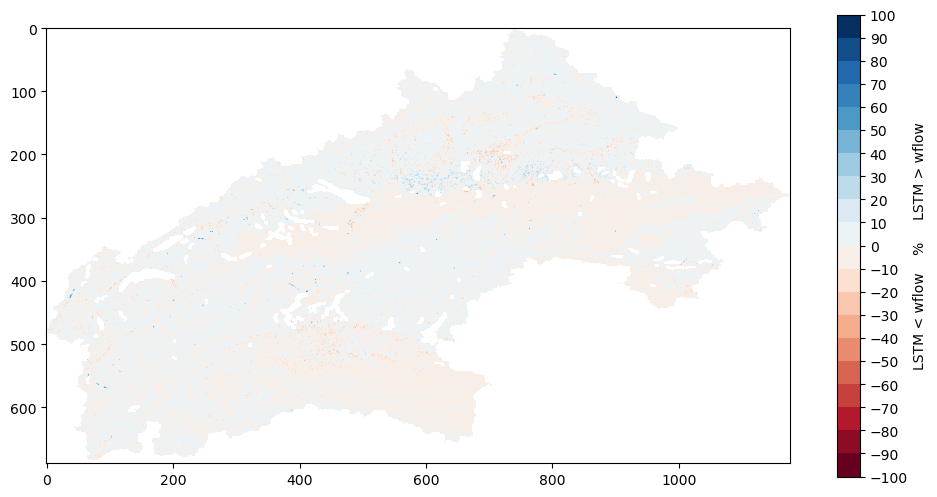

In [65]:
# map percent bias
pbias = map_pbias(y_target, y_pred, figsize = (12, 12), kwargs_imshow = {"vmin":-100, "vmax":100 }, return_pbias=True)

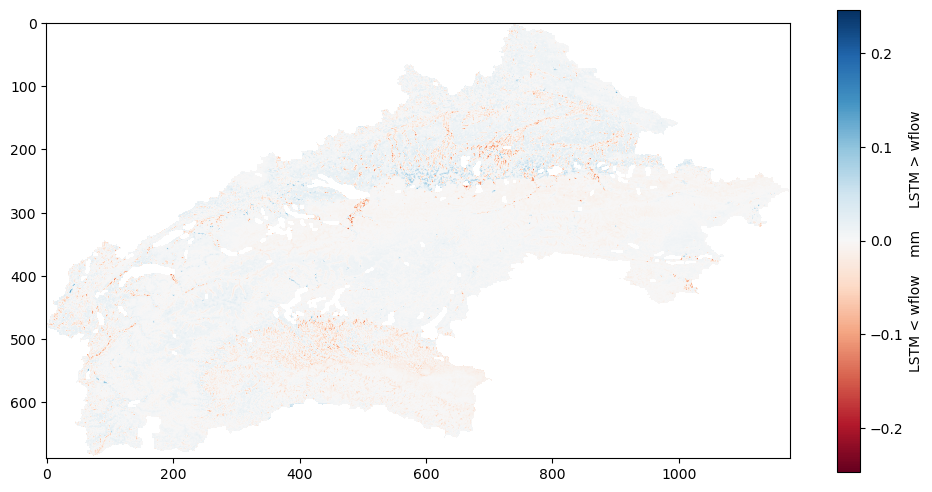

In [66]:
bias = map_bias(y_target, y_pred, figsize = (12, 12), return_bias=True)

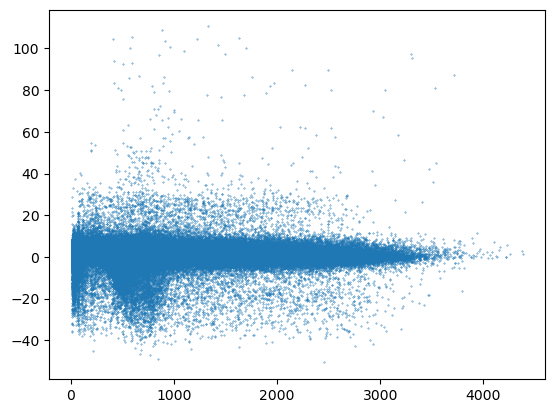

In [77]:
plt.scatter(wflow_dem.values.flatten(), pbias.values.flatten(), s=0.1, alpha=1)

In [115]:
# clusters
def reclass(arr, classes):
    """Returns a 2D array with reclassified values 

    Parameters
    ----------
    arr: NDArray | xr.DataArray
        The input array to be reclassified
    classes: List[int,float]

    Returns
    -------
    """
    if isinstance(arr, xr.DataArray):
        for ic in range(len(classes)):
            print(ic, len(classes)-1)
            if ic < len(classes) - 1:
                arr = arr.where( ~((arr >= classes[ic]) & (arr < classes[ic +1])), ic)
            else:
                arr = arr.where( ~(arr >= classes[ic]), ic)
    return arr
            

In [116]:
cc_re = reclass(wflow_landuse.where(~missing_mask.compute()), [100,200,300,400,500])

0 4
1 4
2 4
3 4
4 4


In [ ]:
dd = bias.to_dataset(name="pbias")
#dd = kge[...,0].to_dataset(name="kge")
dd["landuse"] =  cc_re

df = dd.to_dataframe().dropna().reset_index().drop(["layer", "spatial_ref","lat","lon"], axis=1)

import seaborn as sns

sns.boxenplot(df,x="landuse", y="pbias")

In [266]:
# map bias
#map_bias(y_target, y_pred, figsize = (12, 12))

In [267]:
# correlation
# map_pearson(y_target, y_pred)

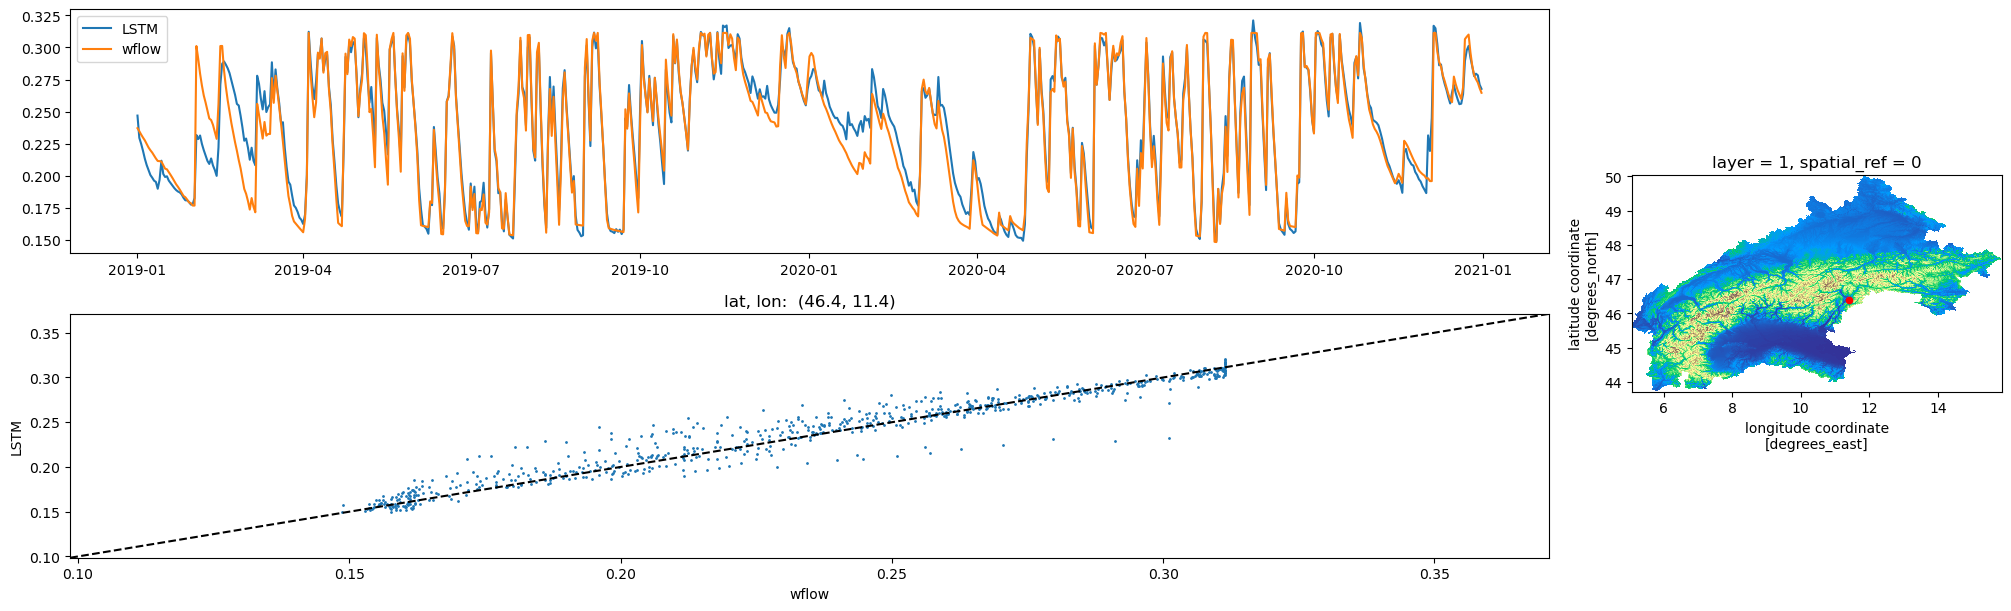

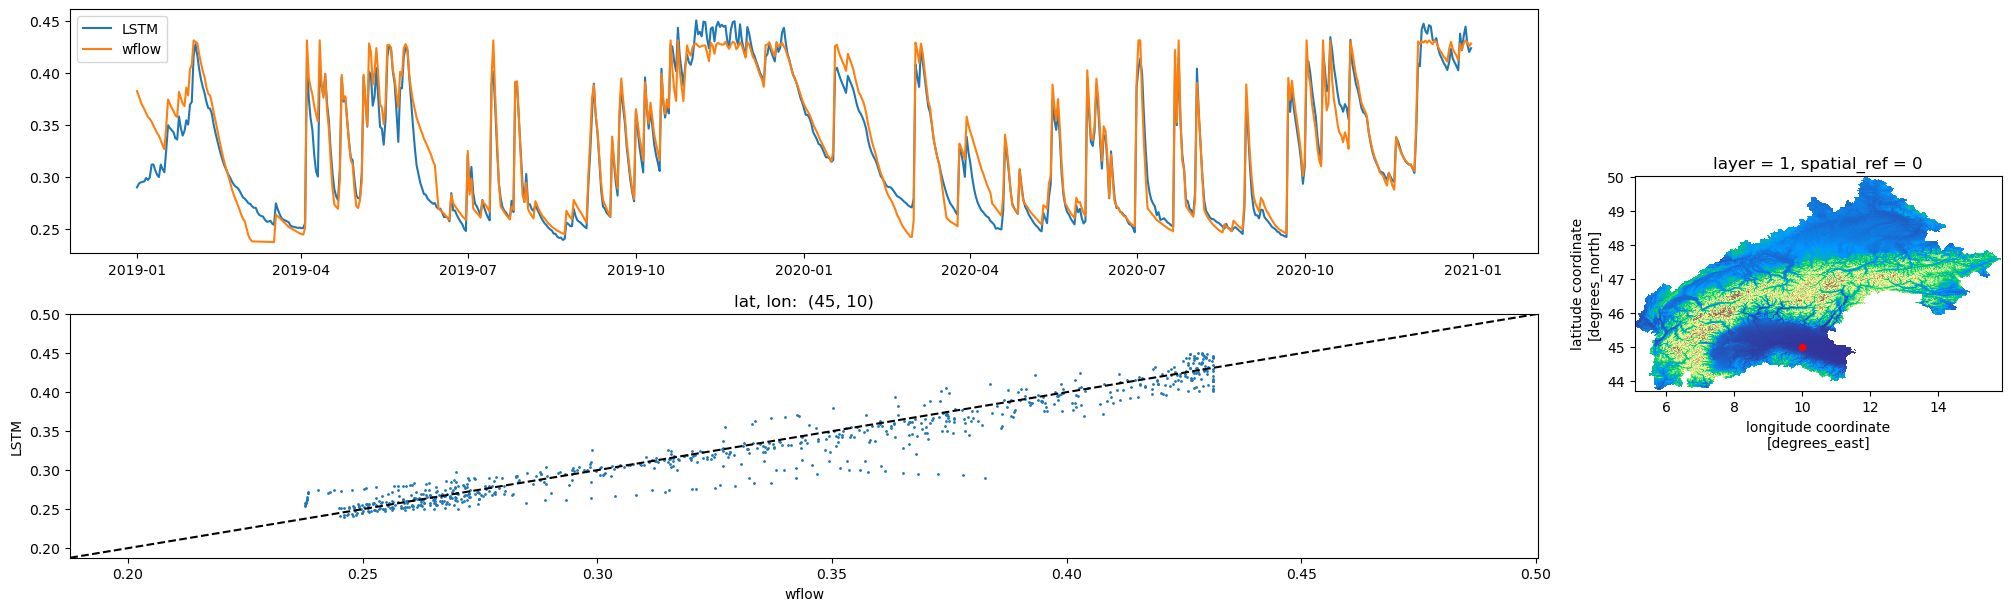

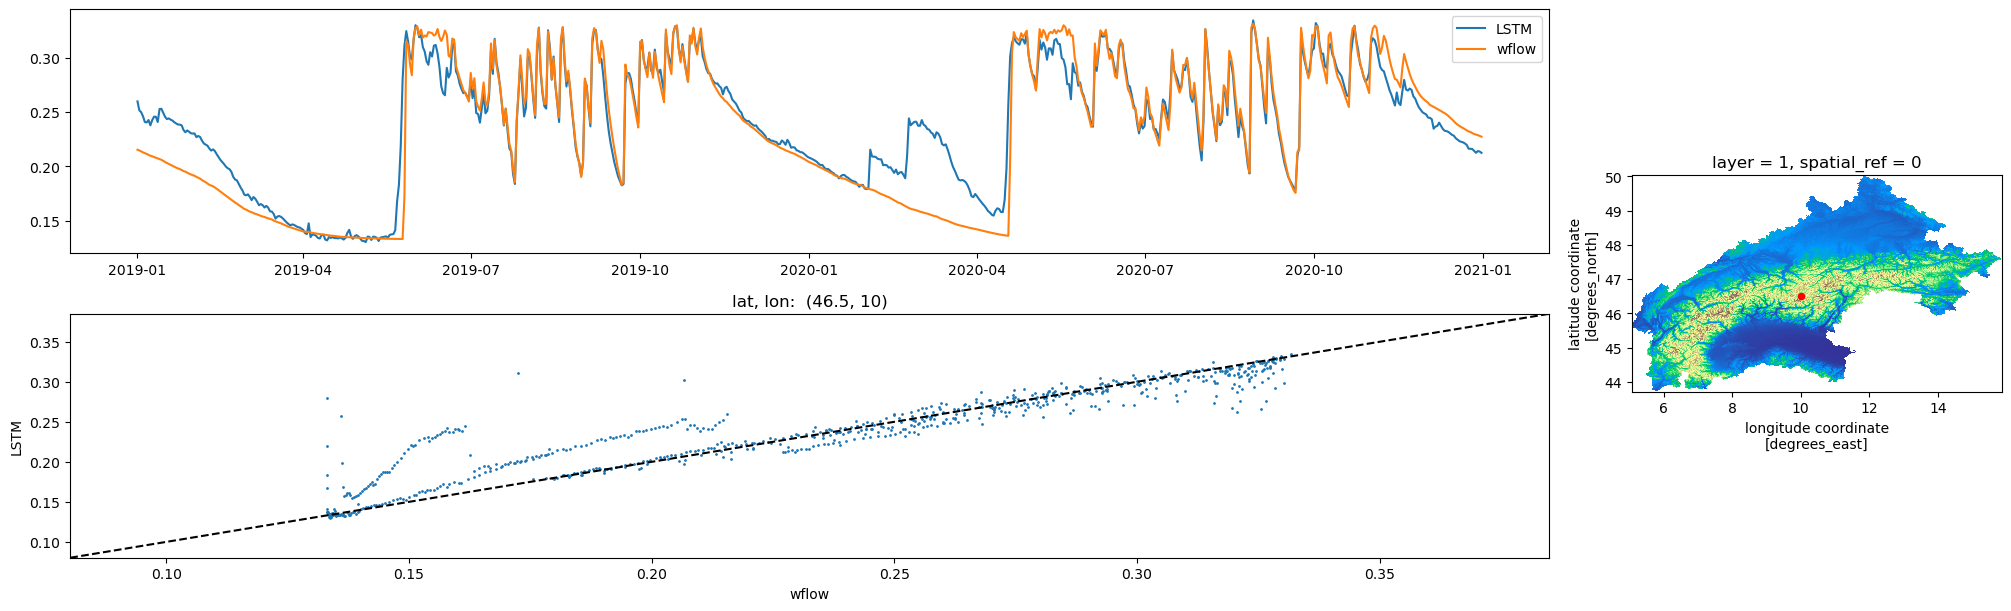

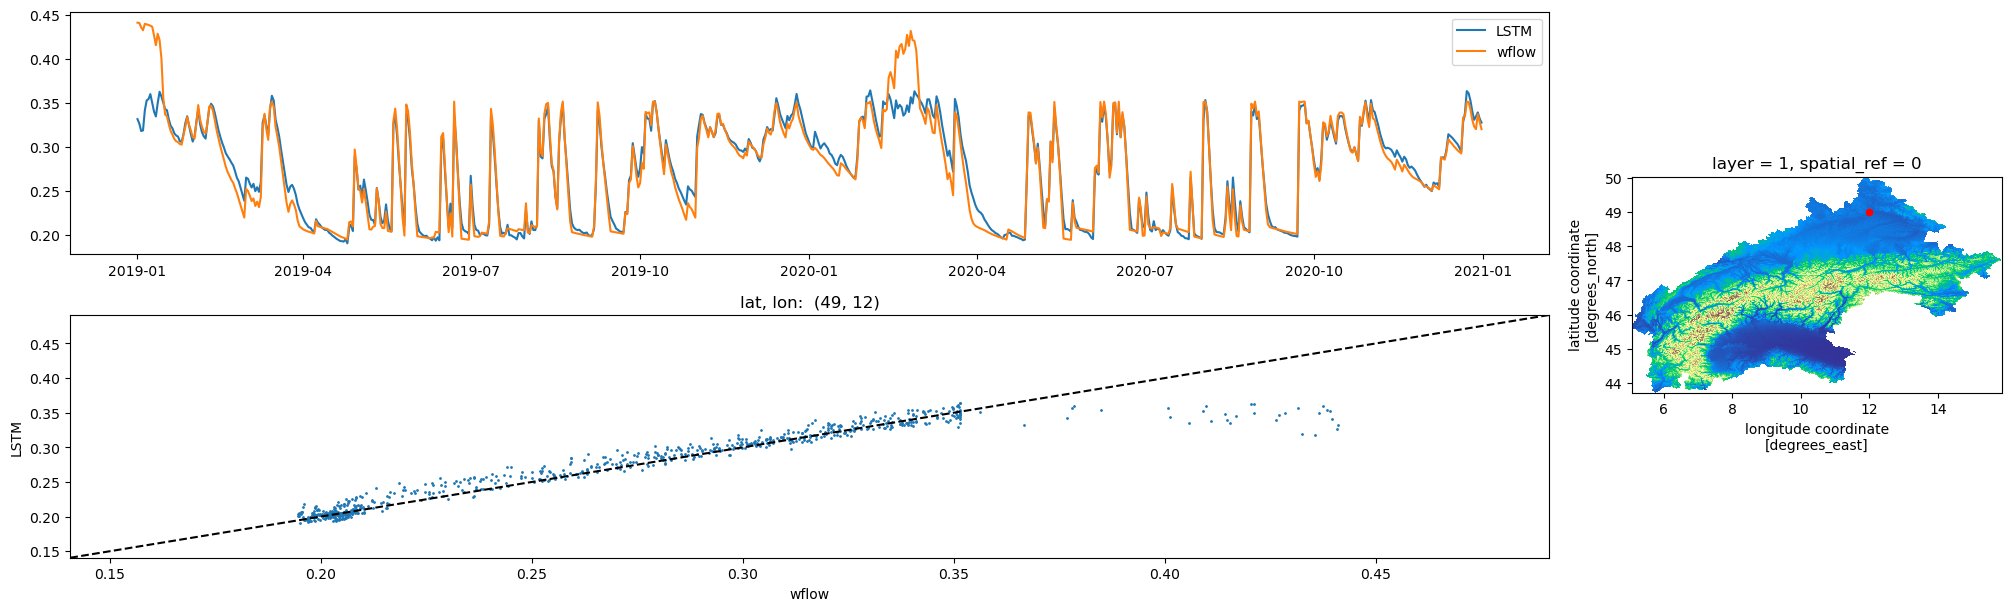

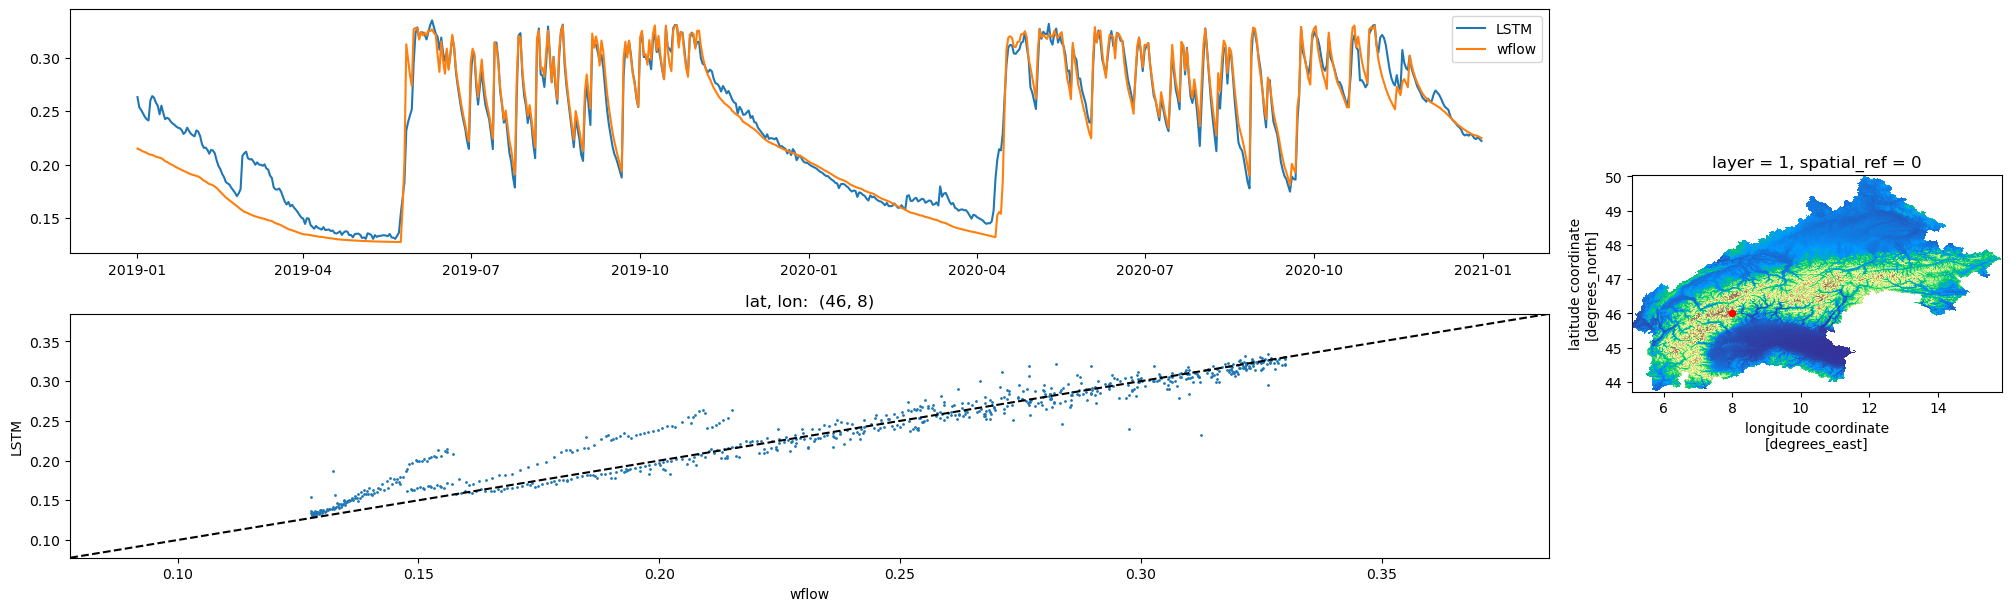

In [48]:
ts_compare(y_target, y_pred, lat = [46.4, 45, 46.5, 49, 46], lon = [11.4, 10, 10,12,8], bkg_map=wflow_dem)

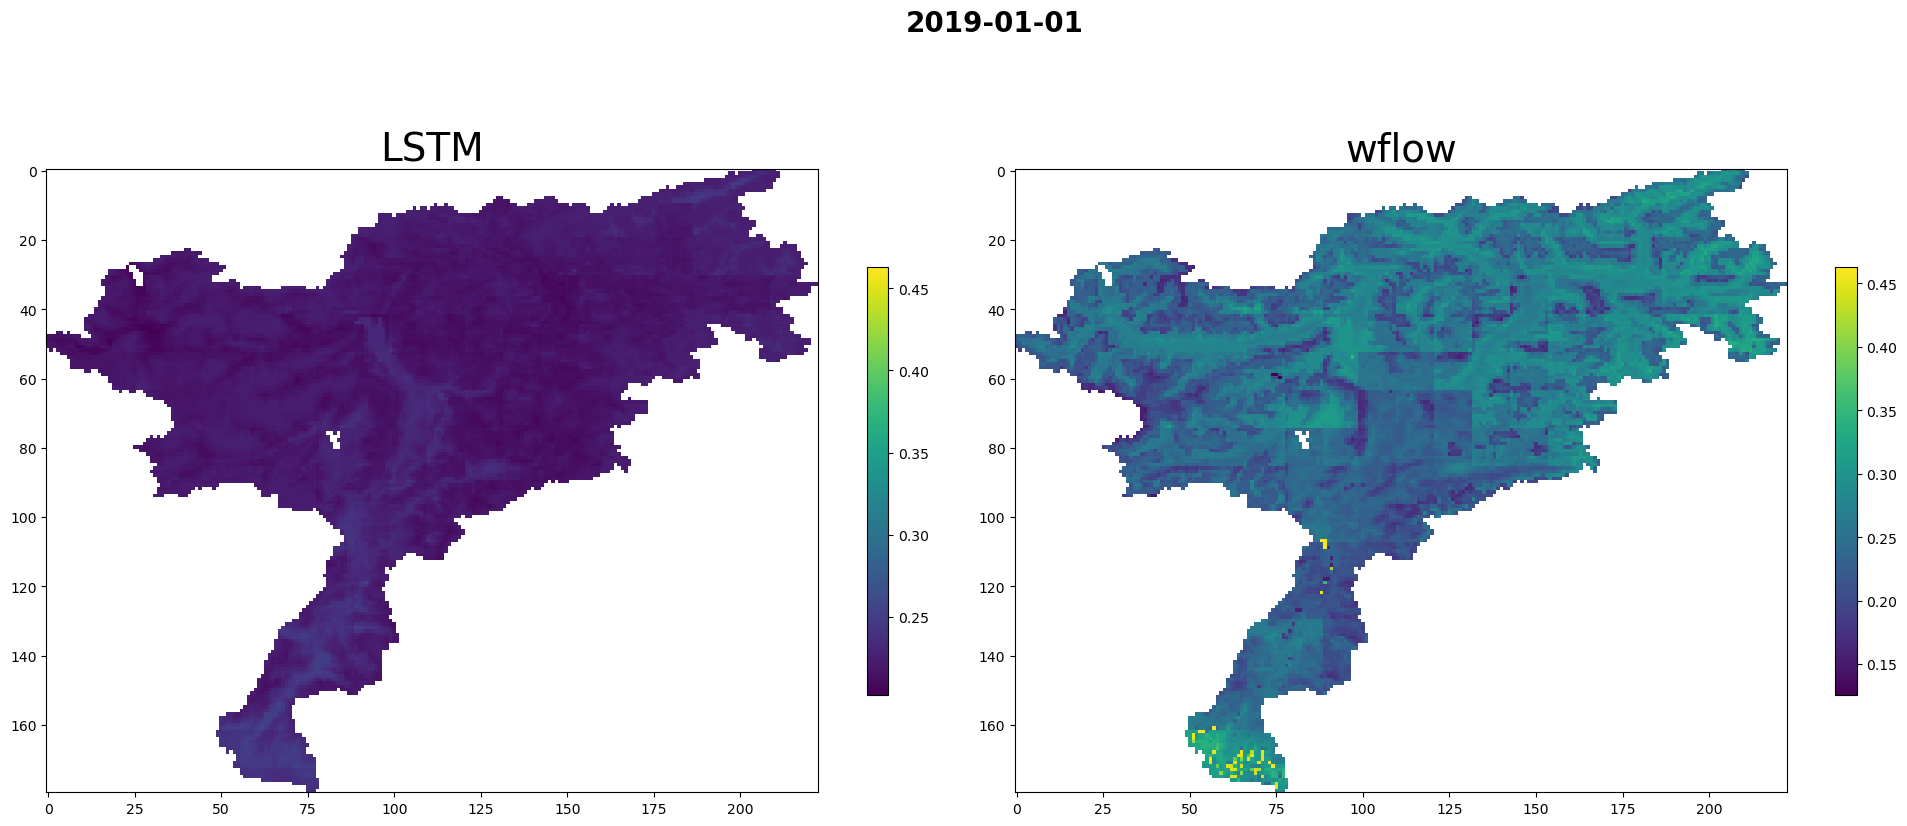

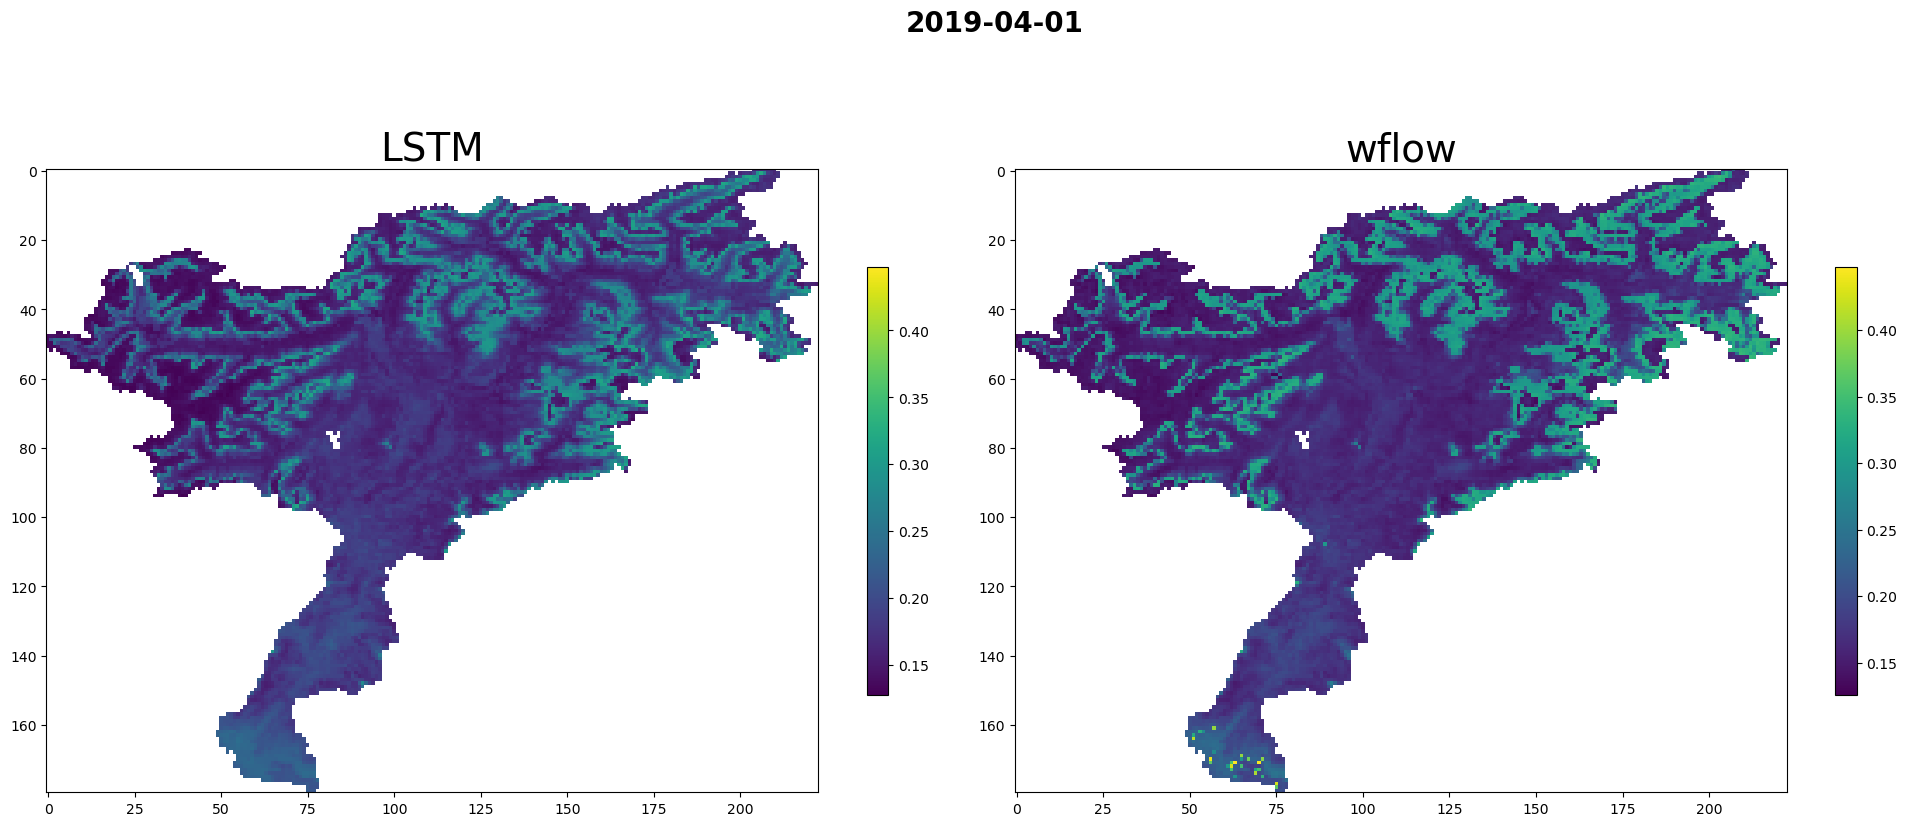

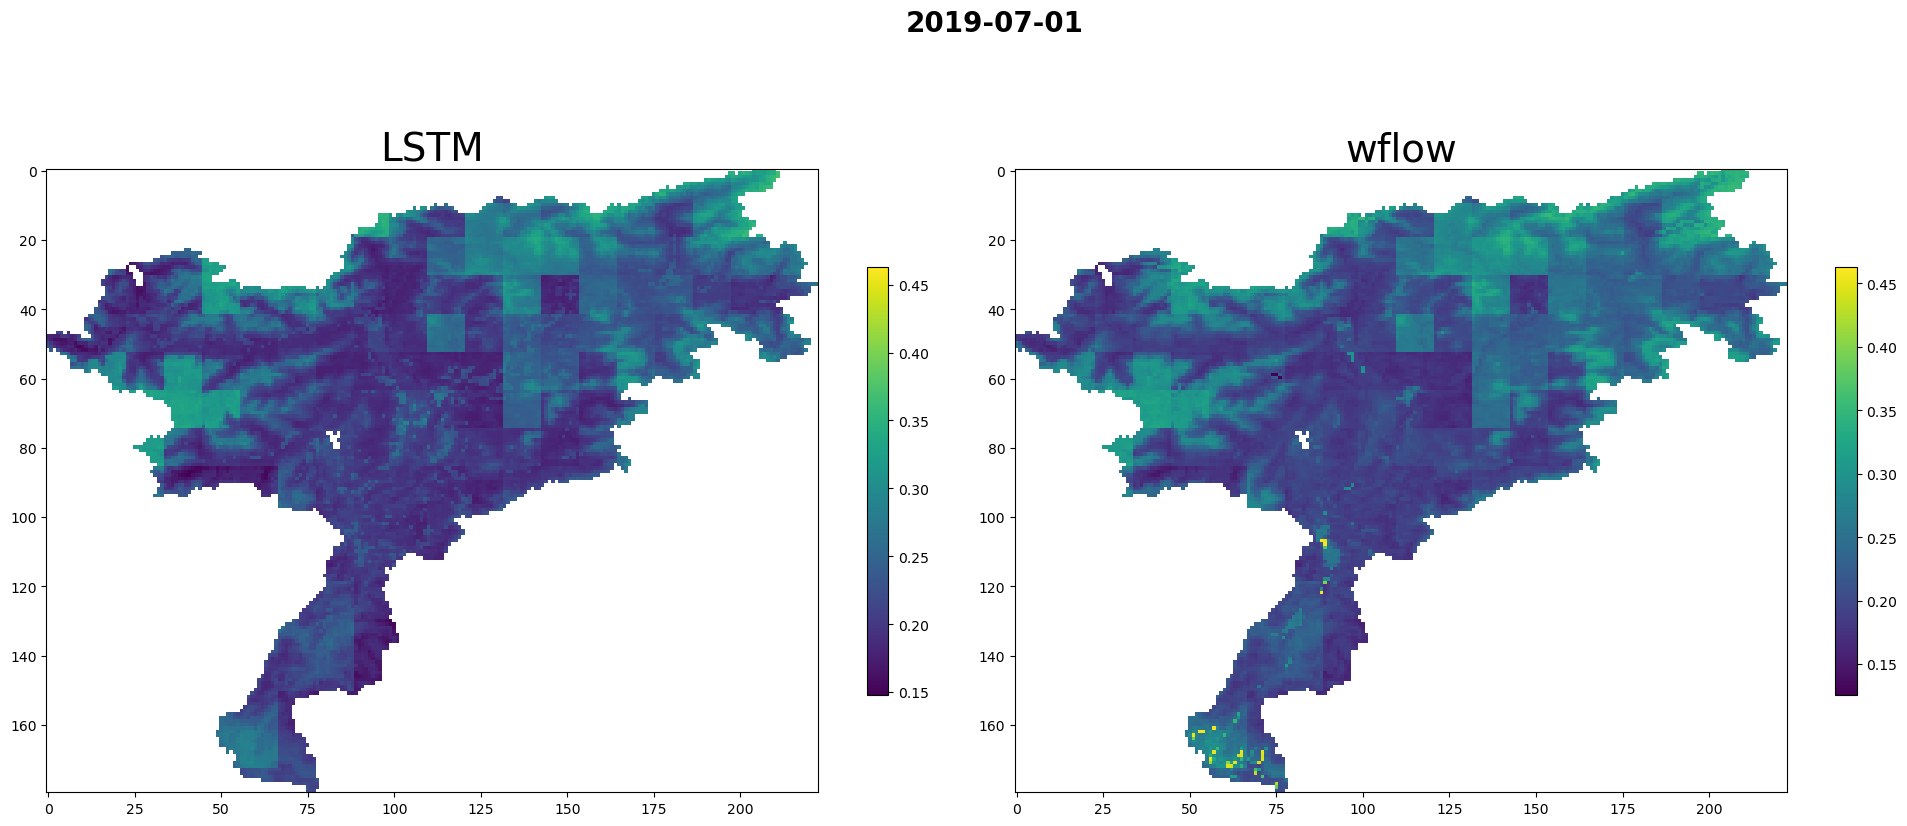

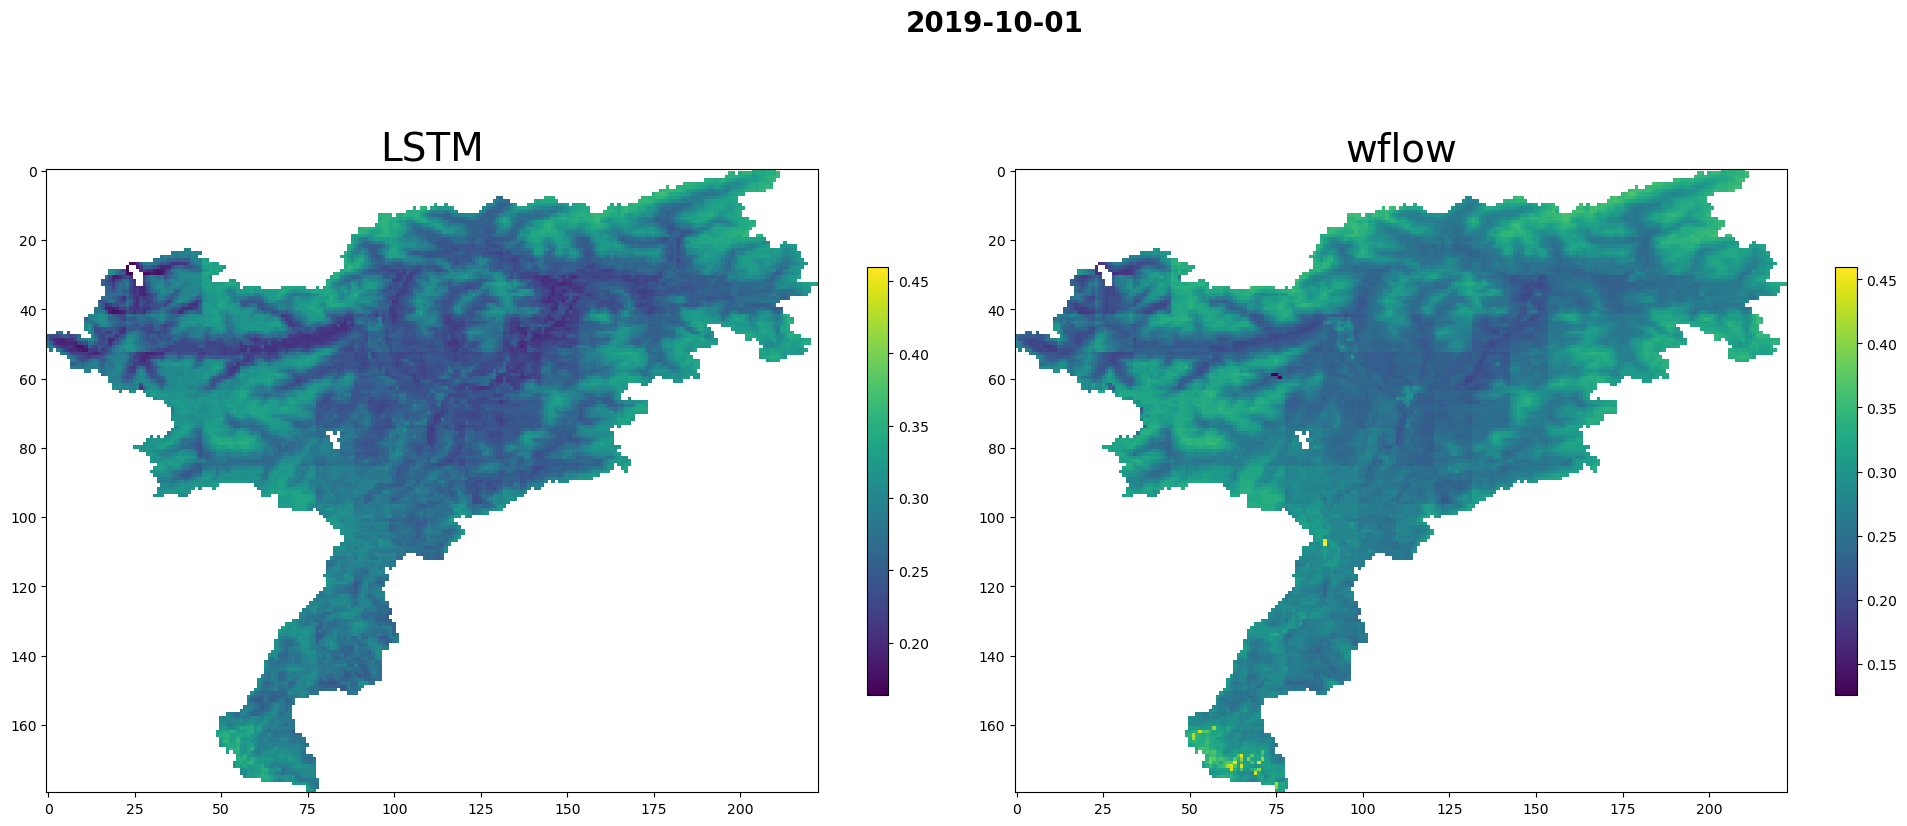

In [269]:
map_at_timesteps(y_target, y_pred,dates=["2019-01-01","2019-04-01", "2019-07-01", "2019-10-01"])

## ET

In [70]:
y_target_et, y_pred_et = prepare_for_plotting(y_target=Y_test[:,:,[1]], y_pred = yhat[:,:,[1]], shape = (lat, lon, time), coords  = targets.sel(time=test_range).coords)
y_target_et.shape

(689, 1177, 731)

In [71]:
y_target_et = (y_target_et*y_std[1]) + y_m[1]

In [72]:
if remove_lakes:
    y_target_et = y_target_et.where(~mask_lakes[...,None])
    y_pred_et = y_pred_et.where(~mask_lakes[...,None])

In [ ]:
map_pbias(y_target_et, y_pred_et, figsize = (10, 10), kwargs_imshow = {"vmin":-100, "vmax":100 })

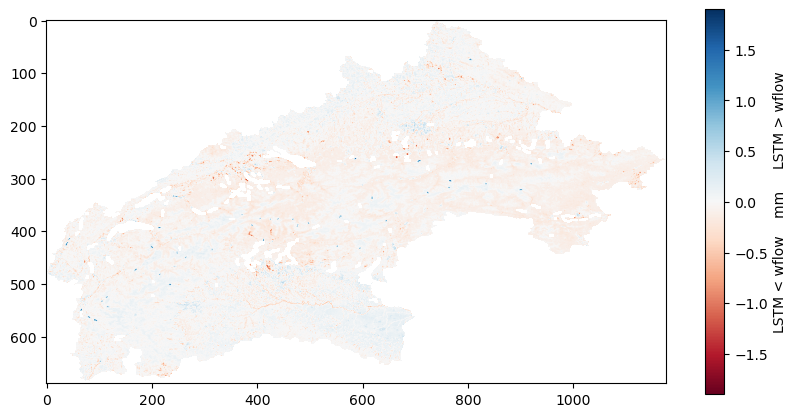

In [75]:
map_bias(y_target_et, y_pred_et, figsize = (10, 10))

In [140]:
kge = xr.apply_ufunc(compute_kge, y_pred_et, y_target_et, 
                     input_core_dims=[["time"],["time"]] , 
                     output_core_dims= [["kge"]], 
                     output_dtypes=[float],
                     vectorize=True,
                     dask="parallelized",
                     dask_gufunc_kwargs = {"output_sizes":{"kge":4}}
                    )
kge  = kge.compute()
kge = kge.assign_coords({"kge":["kge","r", "alpha", "beta"]})

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


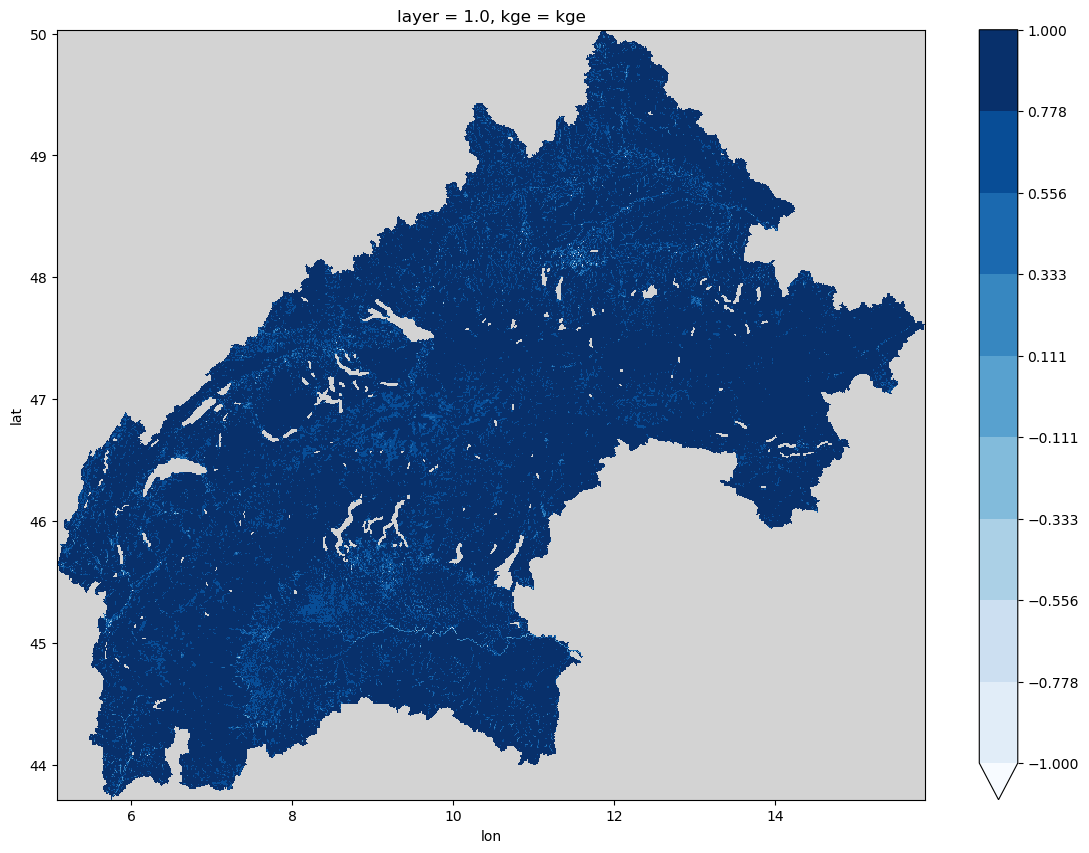

In [141]:
kge[...,0].plot(cmap=cmap,figsize=(14,10), levels=10, vmax=1)

In [76]:
plt.figure(figsize=(20,5))
plt.scatter(wflow_dem.values.flatten(), kge[...,0].values.flatten(), s=1, alpha=1)

NameError: name 'kge' is not defined

<Figure size 2000x500 with 0 Axes>

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<AxesSubplot: xlabel='landuse', ylabel='pbias'>

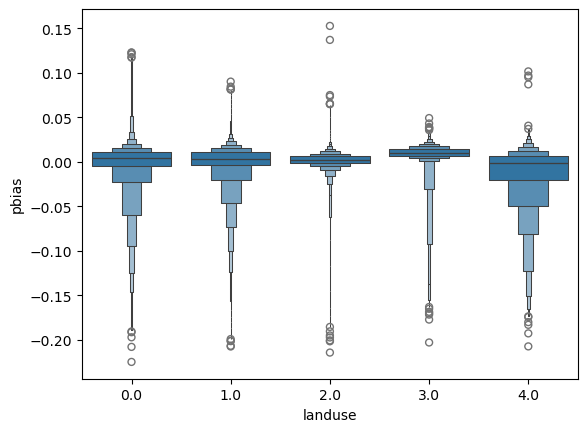

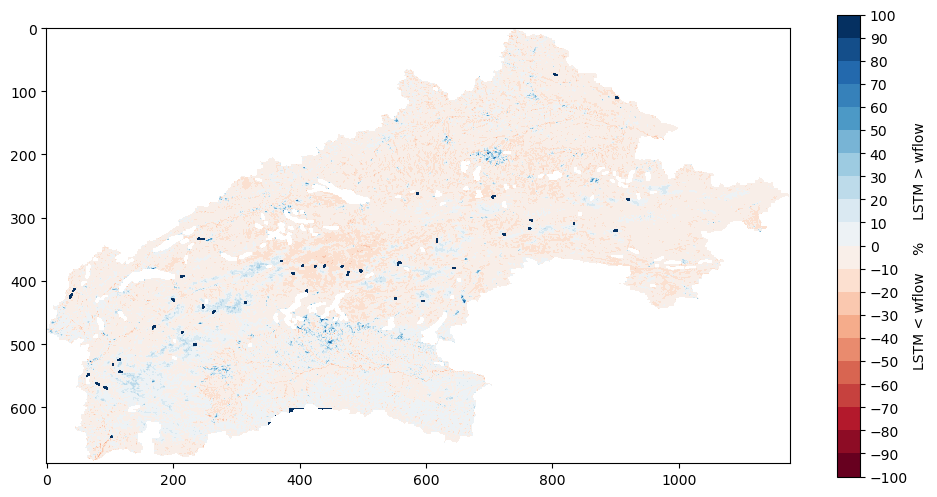

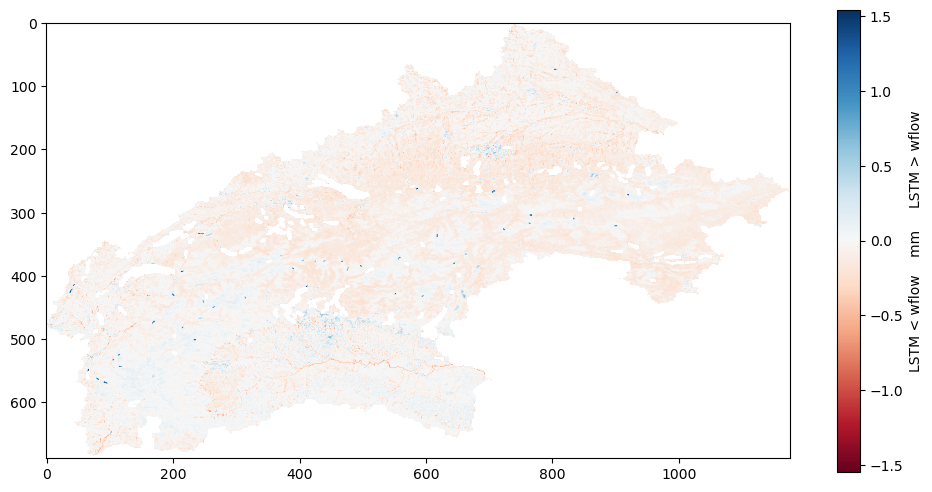

In [146]:
pbias = map_pbias(y_target_et, y_pred_et, figsize = (12, 12), kwargs_imshow = {"vmin":-100, "vmax":100 }, return_pbias=True)
bias = map_bias(y_target_et, y_pred_et , figsize = (12, 12), return_bias=True)

In [163]:
#dd = bias.to_dataset(name="pbias")
dd = kge[...,1].to_dataset(name="pbias")
dd["landuse"] =  cc_re

df = dd.to_dataframe().dropna().reset_index().drop(["layer", "spatial_ref","lat","lon"], axis=1)

import seaborn as sns

/home/iferrario/.local/miniforge/envs/emulator/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<AxesSubplot: xlabel='landuse', ylabel='pbias'>

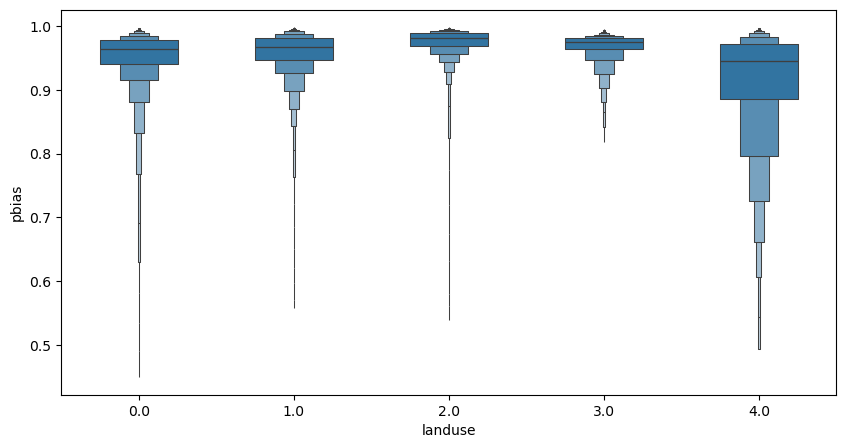

In [176]:
plt.figure(figsize=(10,5))
sns.boxenplot(df,x="landuse", y="pbias",showfliers=False,width=0.5,)

In [42]:
# correlation
# map_pearson(y_target_et, y_pred_et)

In [ ]:
ts_compare(y_target_et, y_pred_et, lat = [46.4, 45, 46.5, 49, 46], lon = [11.4, 10, 10,12,8], bkg_map=wflow_dem)

In [ ]:
#plt.plot(np.unique(y_pred_et))

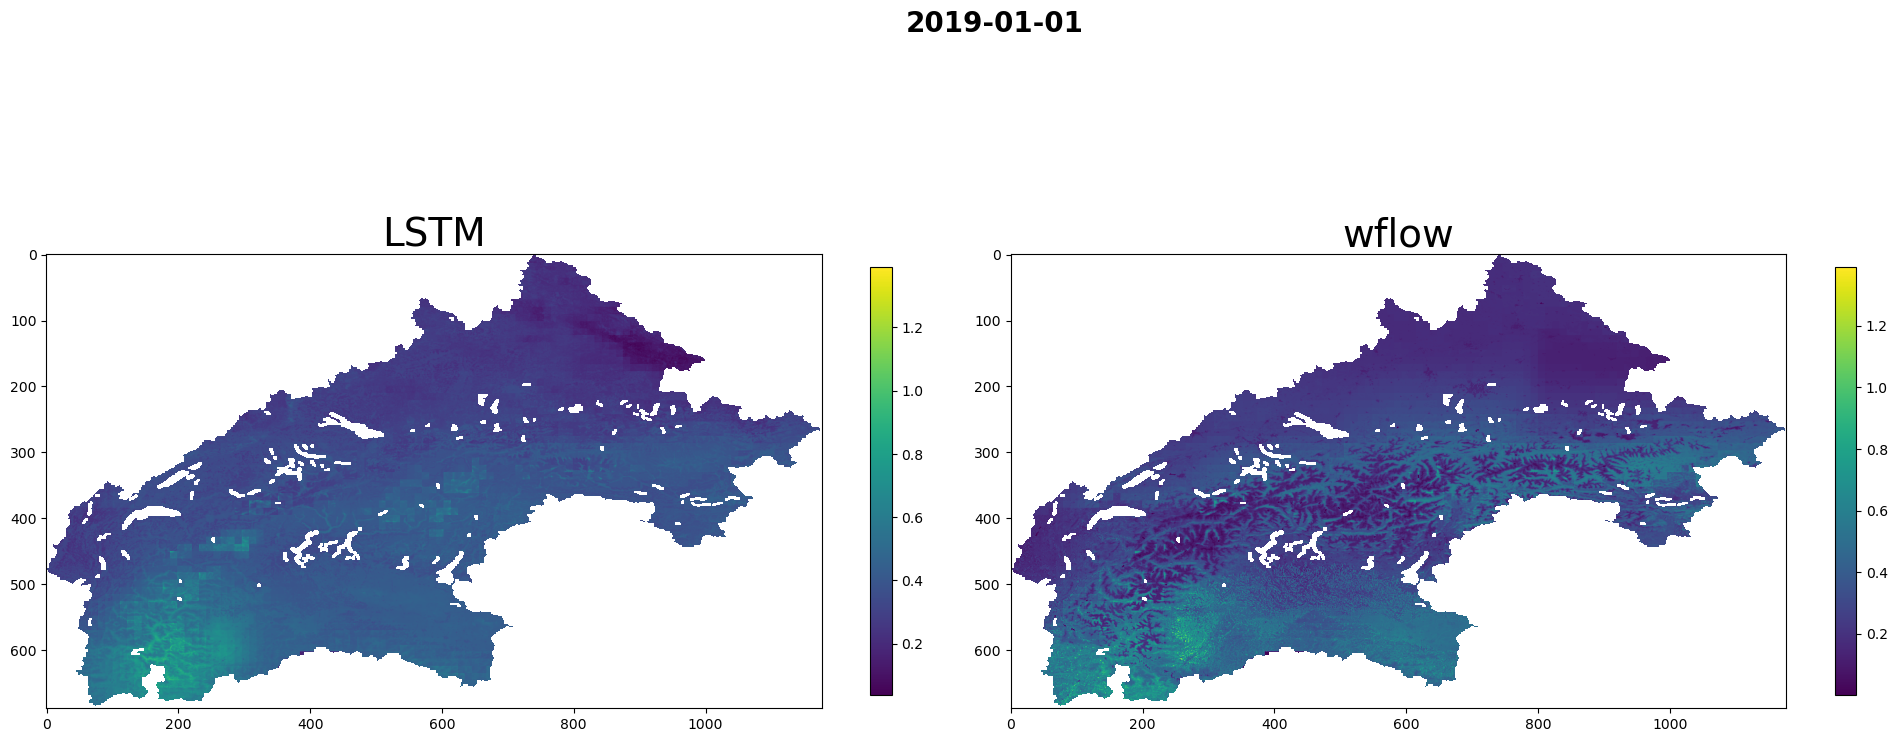

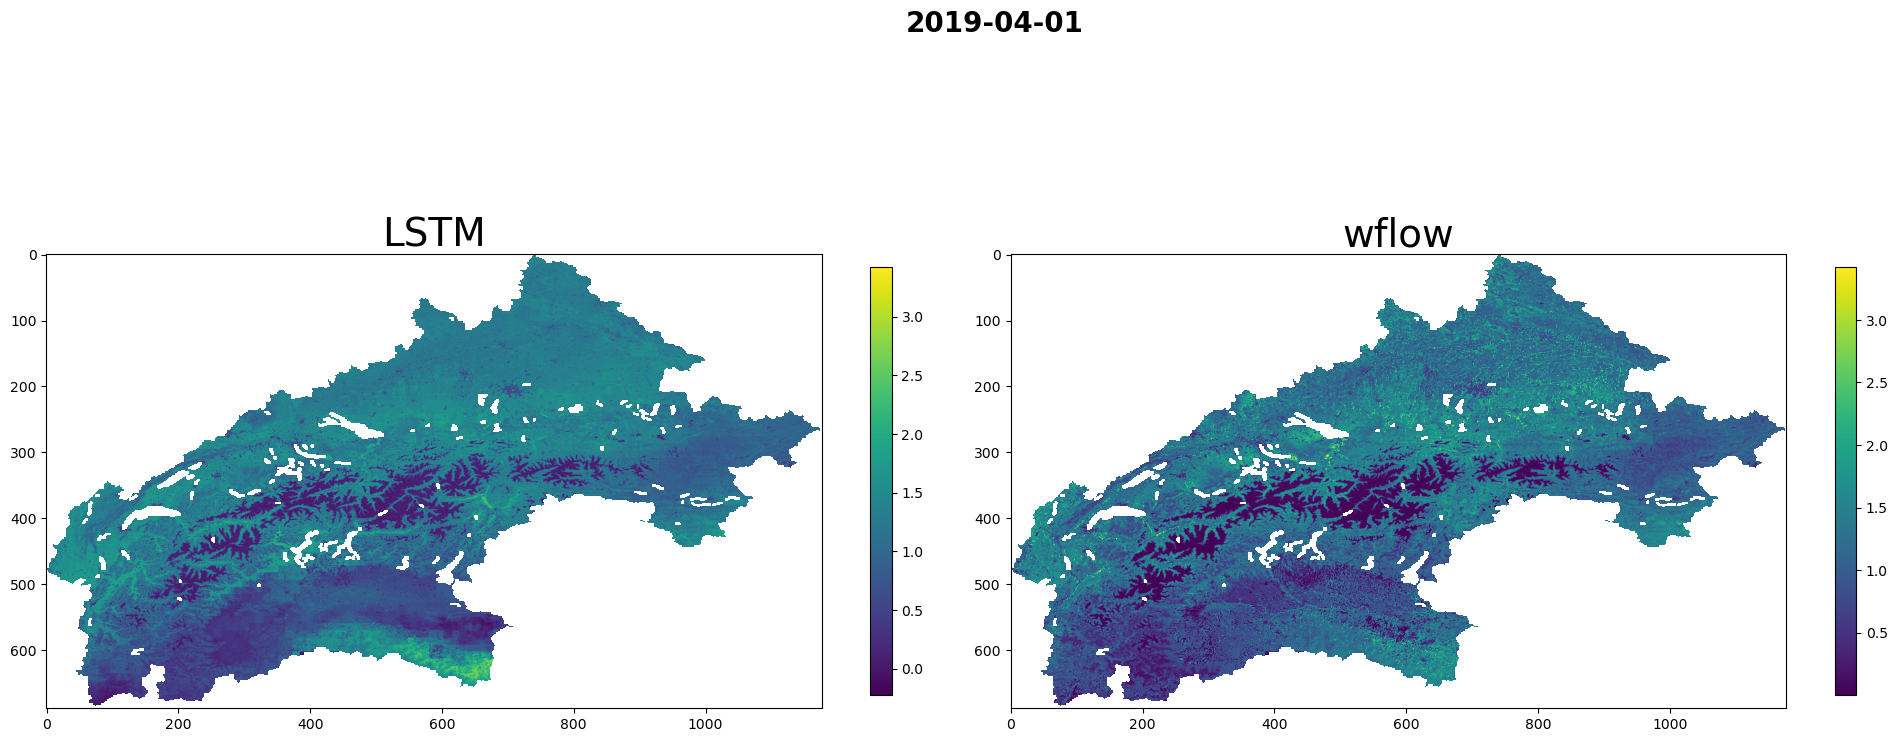

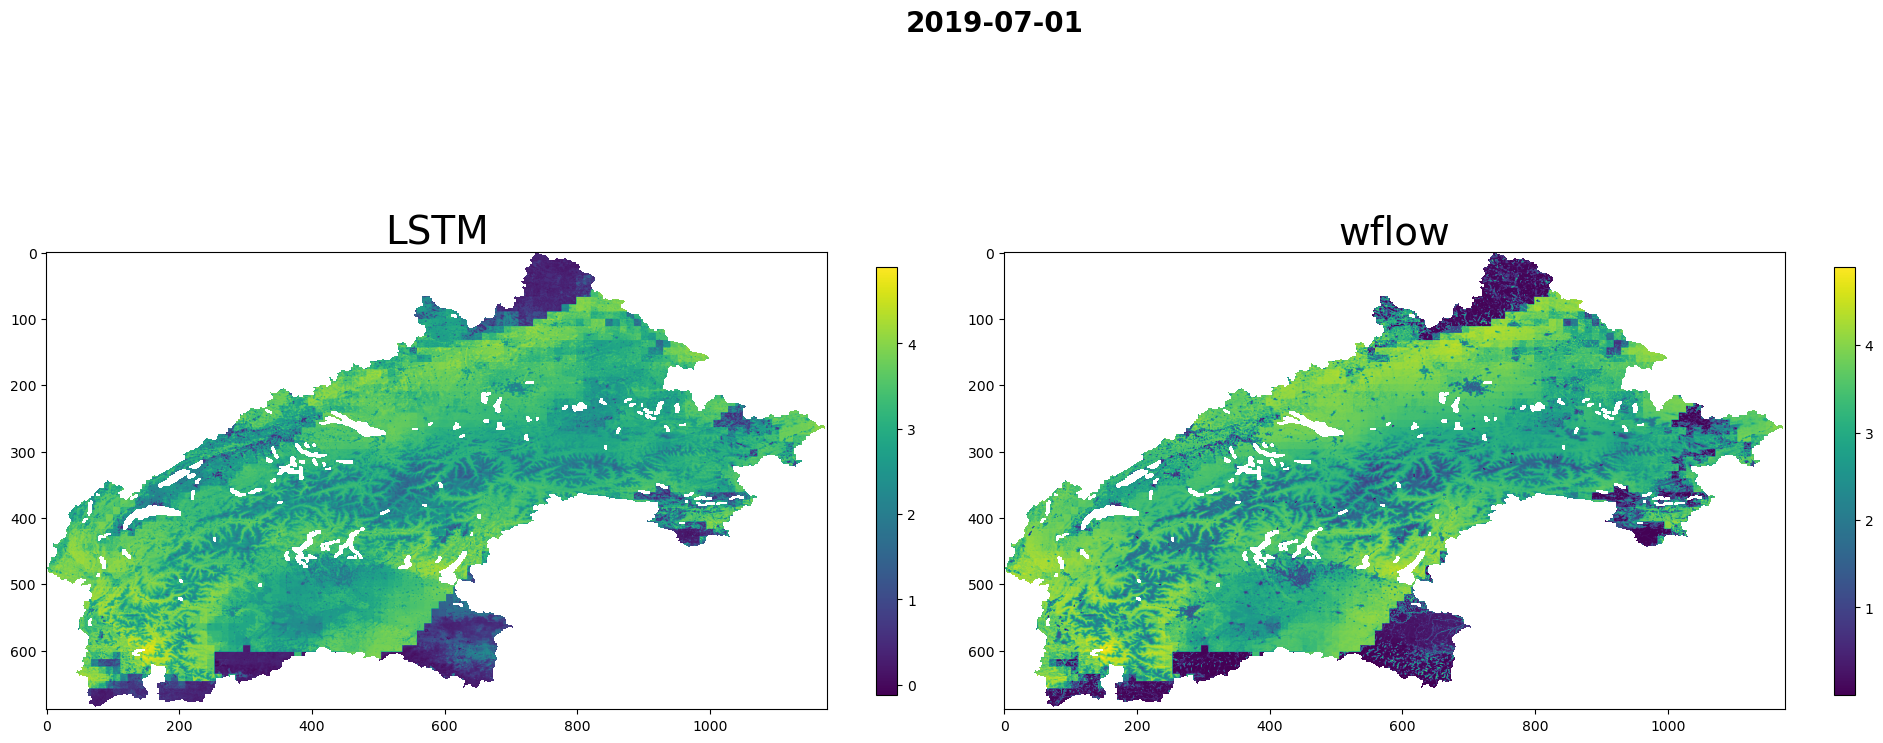

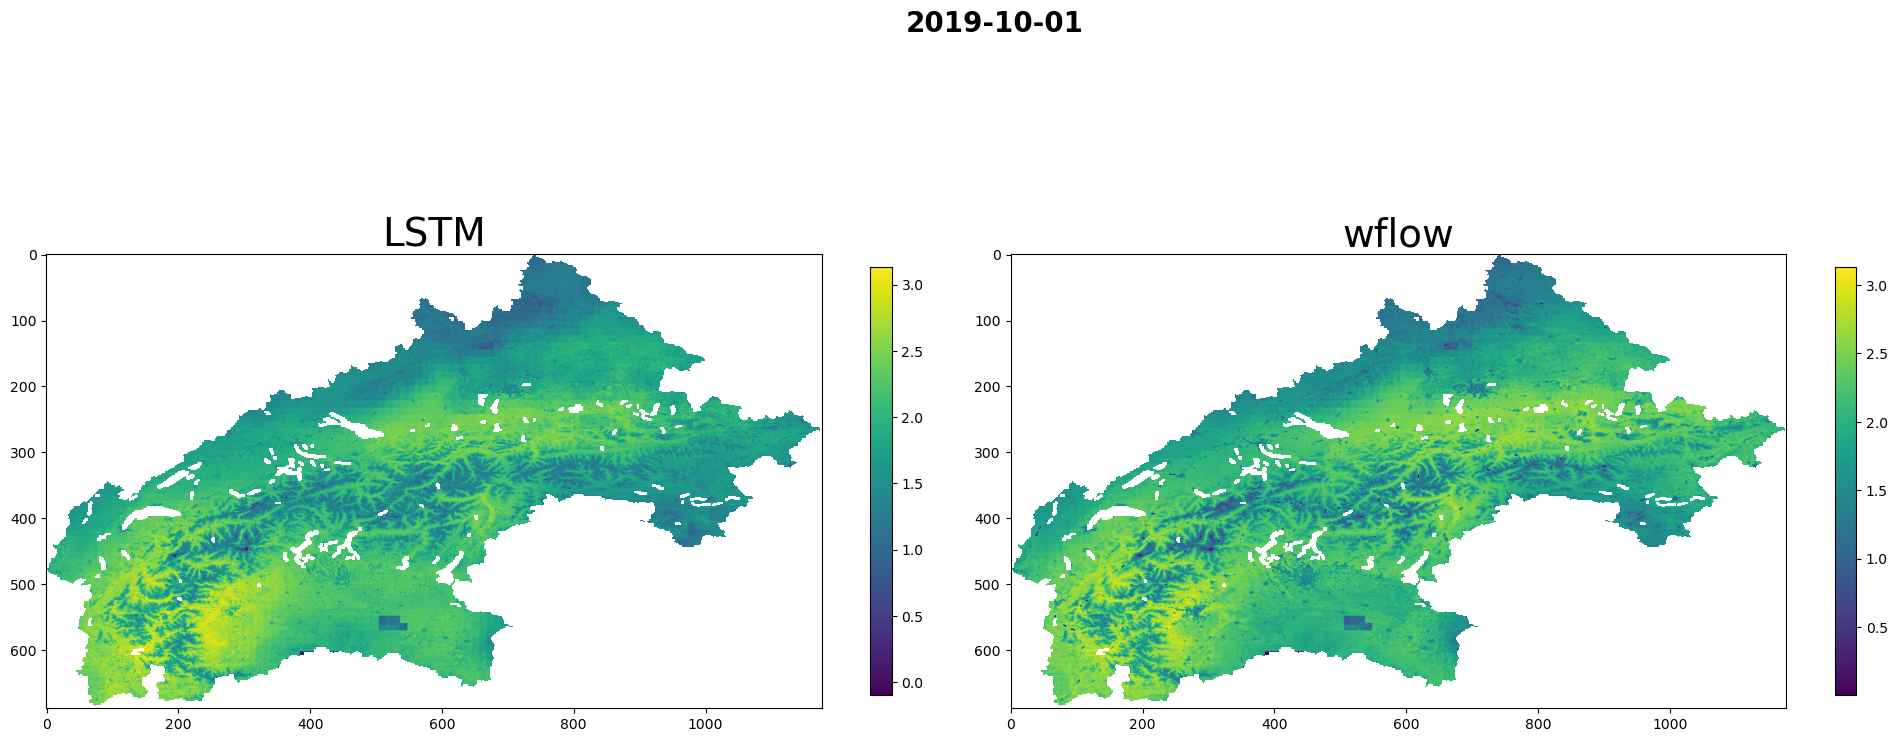

In [47]:
map_at_timesteps(y_target_et, y_pred_et,dates=["2019-01-01","2019-04-01", "2019-07-01", "2019-10-01"])